# Training the model with optimized hyperparameters on the full set (training + validation) and predicting on the test set

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Loading train, validation and test sets

In [ ]:
ds = tfds.load('malaria', 
               split=('train[:80%]', 'train[80%:]'), 
               shuffle_files=False,
              data_dir='/content/gdrive/MyDrive/datasets/Malaria',
               batch_size=32,
              download=True,
              as_supervised=True,
              with_info=False)

In [ ]:
def build_model(init_filters, kernel_size, num_convols):
    inputs = keras.Input(shape=(None, None, 3))
    x = keras.layers.Rescaling(scale=1.0 / 255)(inputs)
    num_chan = init_filters
    x = keras.layers.Conv2D(
        filters=init_filters,
        kernel_size=kernel_size,
        strides=(1, 1),
        padding="valid",
        activation='relu')(x)
    for i in range(num_convols):
        # i is the number of convlutions with MaxPooling
        # There is another convolution with GlobalMaxPooling
        if i != 0:
            x = keras.layers.MaxPooling2D(
                pool_size=(2, 2), 
                strides=None, 
                padding="valid")(x)
            num_chan = init_filters * (i + 1)
            x = keras.layers.Conv2D(
                filters=num_chan,
                kernel_size=kernel_size,
                strides=(1, 1),
                padding="valid",
                activation='relu')(x)
    x = keras.layers.GlobalMaxPooling2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(units=num_chan,
                            activation="relu",
                          kernel_regularizer=None)(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='Adam',
         loss='binary_crossentropy',
         metrics=['accuracy'])    
    return model

In [ ]:
model = build_model(64, 2, 5)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 rescaling (Rescaling)       (None, None, None, 3)     0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 64)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 128)   32896     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 128)  0         
 2D)                                                         

In [ ]:
history = model.fit(
    ds[0],
    epochs=10,
    verbose="auto")

Epoch 1/10
689/689 [==============================] - 326s 459ms/step - loss: 0.2063 - accuracy: 0.9185
Epoch 2/10
689/689 [==============================] - 50s 72ms/step - loss: 0.1391 - accuracy: 0.9575
Epoch 3/10
689/689 [==============================] - 50s 72ms/step - loss: 0.1303 - accuracy: 0.9596
Epoch 4/10
689/689 [==============================] - 49s 72ms/step - loss: 0.1254 - accuracy: 0.9604
Epoch 5/10
689/689 [==============================] - 49s 71ms/step - loss: 0.1195 - accuracy: 0.9626
Epoch 6/10
689/689 [==============================] - 49s 71ms/step - loss: 0.1132 - accuracy: 0.9641
Epoch 7/10
689/689 [==============================] - 49s 71ms/step - loss: 0.1054 - accuracy: 0.9662
Epoch 8/10
689/689 [==============================] - 50s 72ms/step - loss: 0.0987 - accuracy: 0.9667
Epoch 9/10
689/689 [==============================] - 49s 71ms/step - loss: 0.0908 - accuracy: 0.9690
Epoch 10/10
689/689 [==============================] - 49s 71ms/step - loss: 0.0

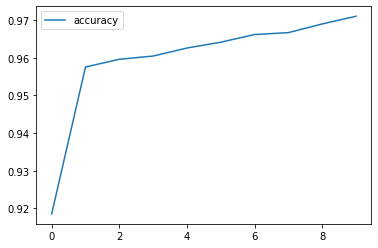

In [ ]:
pd.DataFrame({'accuracy': history.history['accuracy']}).plot.line();

In [ ]:
 max(history.history['accuracy'])

0.9710151553153992

In [ ]:
model.evaluate(ds[1])

173/173 [==============================] - 16s 90ms/step - loss: 0.1799 - accuracy: 0.9545


[0.17988701164722443, 0.954463005065918]

# Accuracy 95.4% on the test set